# Assignment: Segmenting and Clustering Neighborhoods in Toronto

## <a name="dataframe"></a>1. Create Dataframe

### 1.1. Retrieve data

In [1]:
import pandas as pd

# Data source
urlWiki = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# Read in data
torontoTable = pd.read_html(urlWiki)[0]

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
colNames = list(['PostalCode', 'Borough', 'Neighborhood'])
torontoTable.columns = colNames


### 1.2. Remove unassigned Boroughs

In [2]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
#
# Count entries without assigned borough
cntNotAss = torontoTable[torontoTable['Borough']=='Not assigned']['Borough'].count()
# New dataframe: reset index to make it start at zero
torontoTableClean = torontoTable[torontoTable['Borough']!='Not assigned'].reset_index(drop=True)
# Check results
print('Entries without assigned borough:  {}'.format(cntNotAss))
print('Data size of original table:      {} lines'.format(torontoTable.shape[0]))
print('Data size of new table:           {} lines'.format(torontoTableClean.shape[0]))

Entries without assigned borough:  77
Data size of original table:      288 lines
Data size of new table:           211 lines


### 1.3. Name unassigned Neighbourhoods

In [3]:
# Find entries with unassigned Neighbourhoods
tmpIdx = torontoTableClean['Neighborhood']=='Not assigned'

# Before
torontoTableClean[tmpIdx]

,PostalCode,Borough,Neighborhood
6,M7A,Queen's Park,Not assigned


In [4]:
# Rename: it is only one entry. We could do it manually but this will work just fine.
torontoTableClean.loc[tmpIdx, 'Neighborhood'] = torontoTableClean.loc[tmpIdx, 'Borough']

In [5]:
# After
torontoTableClean[tmpIdx]

,PostalCode,Borough,Neighborhood
6,M7A,Queen's Park,Queen's Park


### 1.4. Combine Neighborhoods

#### 1.4.1 Without groupby()

In [6]:
# More than one neighborhood can exist in one postal code area.
# These rows will be combined into one row with the neighborhoods separated with a comma

# Get set of unique PostalCode entries
uniquePostalCodes = torontoTableClean['PostalCode'].unique()
print('Number of unique postal codes: {}'.format(len(uniquePostalCodes)))

# New dataframe with combined neighbourhoods
torontoTableComb1 = pd.DataFrame(columns = colNames)

# Loop over unique postal codes
for postalCode in uniquePostalCodes:
    # Find all entries matching the current postal code
    tmpDf = torontoTableClean[torontoTableClean['PostalCode']==postalCode].reset_index(drop=True)
    # Loop over temporary table
    tmpStr=[]
    for idx, row in tmpDf.iterrows():
        # Combine neighbourhoods
        tmpStr.append(row.Neighborhood)
    # Create comma-separated string
    strNeighb = ', '.join(tmpStr)
    # Append new entry
    torontoTableComb1 = torontoTableComb1.append({'PostalCode': postalCode, 'Borough': tmpDf.loc[0, 'Borough'], 'Neighborhood': strNeighb}, ignore_index=True)


Number of unique postal codes: 103


#### 1.4.2 Using groupby()

In [7]:
# More than one neighborhood can exist in one postal code area.
# These rows will be combined into one row with the neighborhoods separated with a comma

# Get set of unique PostalCode entries
uniquePostalCodes = torontoTableClean['PostalCode'].unique()
print('Number of unique postal codes: {}'.format(len(uniquePostalCodes)))

torontoTableComb2 = torontoTableClean.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(list)
torontoTableComb2 = torontoTableComb2.sample(frac=1).reset_index()
torontoTableComb2['Neighborhood'] = torontoTableComb2['Neighborhood'].str.join(', ')

Number of unique postal codes: 103


### 1.5. Dataframe size

In [8]:
print('Number of rows in combined dataframe: {}'.format(torontoTableComb2.shape[0]))

Number of rows in combined dataframe: 103


## <a name="latlong"></a>2. Get latitude and longitude

### 2.1 Using geopy

In [9]:
# ArcGIS seems to provide results for all postal codes

import numpy as np

# Use Nomimatim instead of geocoder
#!conda install -c conda-forge geopy --yes
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.geocoders import ArcGIS
geolocator = ArcGIS(user_agent="toronto_explorer")

# Arrays for latitude and longitude
arrLat = np.zeros(torontoTableComb2.shape[0])
arrLon = np.zeros(torontoTableComb2.shape[0])

# Loop over all rows and retrieve latitude and longitude for each postal code
for idx, row in torontoTableComb2.iterrows():
    print(idx, end=" ")
    address = '{}, Toronto, Ontario, CA'.format(row.PostalCode)
    print(address, end= "")
    
    location = geolocator.geocode(address)
    
    if (location != None):
        arrLat[idx] = location.latitude
        arrLon[idx] = location.longitude
        print(', lat: {}, long: {}'.format(location.latitude, location.longitude))
    else:
        print(', None')


0 M6E, Toronto, Ontario, CA, lat: 43.68864000000008, long: -79.45101761399997
1 M2N, Toronto, Ontario, CA, lat: 43.76816500000007, long: -79.40741984599998
2 M4H, Toronto, Ontario, CA, lat: 43.70124000000004, long: -79.34982482599997
3 M4L, Toronto, Ontario, CA, lat: 43.66796500000004, long: -79.31466717299998
4 M6C, Toronto, Ontario, CA, lat: 43.69210517800008, long: -79.43035499999996
5 M7R, Toronto, Ontario, CA, lat: 43.648690000000045, long: -79.38543999999996
6 M6L, Toronto, Ontario, CA, lat: 43.71381000000008, long: -79.48830076899998
7 M1K, Toronto, Ontario, CA, lat: 43.72627568400003, long: -79.26362499999993
8 M4B, Toronto, Ontario, CA, lat: 43.707535000000064, long: -79.31177329699995
9 M3M, Toronto, Ontario, CA, lat: 43.73369000000008, long: -79.49674024199999
10 M8Z, Toronto, Ontario, CA, lat: 43.624630000000025, long: -79.52694976199996
11 M8Y, Toronto, Ontario, CA, lat: 43.63283500000006, long: -79.48955044599995
12 M5W, Toronto, Ontario, CA, lat: 43.648690000000045, long

In [10]:
torontoTableComplete1 = torontoTableComb1
torontoTableComplete1['Latitude'] = arrLat
torontoTableComplete1['Longitude'] = arrLon

# Compare to sample of entries shown in assignment
torontoTableComplete1[torontoTableComplete1.isin({'PostalCode': ['M5G', 'M2H', 'M4B', 'M1J', 'M4G']})['PostalCode']]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.707535,-79.311773
23,M4G,East York,Leaside,43.785665,-79.158725
24,M5G,Downtown Toronto,Central Bay Street,43.649620,-79.476141
27,M2H,North York,Hillcrest Village,43.648573,-79.578250
32,M1J,Scarborough,Scarborough Village,43.711740,-79.579181


### 2.2 Using CSV file

In [11]:
# Read in CSV
dfLatLong = pd.read_csv('https://cocl.us/Geospatial_data')

In [12]:
# Rename column for join
dfLatLong.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

In [13]:
# Merge dataframes
torontoTableComplete2 = torontoTableComb2.merge(dfLatLong, on='PostalCode')

In [14]:
# Compare to sample of entries shown in assignment
torontoTableComplete2[torontoTableComplete2.isin({'PostalCode': ['M5G', 'M2H', 'M4B', 'M1J', 'M4G']})['PostalCode']]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
19,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
59,M4G,East York,Leaside,43.709060,-79.363452
90,M2H,North York,Hillcrest Village,43.803762,-79.363452
95,M1J,Scarborough,Scarborough Village,43.744734,-79.239476


### 2.3 Show dataframe

In [15]:
# The results from ArcGIS differ from the values in the CSV file.
# I will only show the values from the CSV

# Show entire dataframe
pd.set_option('display.max_colwidth', -1, 'display.max_rows', 150)
# Show
torontoTableComplete2

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512
1,M2N,North York,Willowdale South,43.770120,-79.408493
2,M4H,East York,Thorncliffe Park,43.705369,-79.349372
3,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
4,M6C,York,Humewood-Cedarvale,43.693781,-79.428191
5,M7R,Mississauga,Canada Post Gateway Processing Centre,43.636966,-79.615819
6,M6L,North York,"Downsview, North Park, Upwood Park",43.713756,-79.490074
7,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M3M,North York,Downsview Central,43.728496,-79.495697


## <a name="clustering"></a> 3. Explore and Cluster the Neighborhoods

### 3.1 Reduce Data Set

In [16]:
# You can decide to work with only boroughs that contain the word Toronto and then replicate 
# the same analysis we did to the New York City data. It is up to you.

torontoTableReduced = torontoTableComplete2[torontoTableComplete2['Borough'].str.contains('Toronto')].reset_index(drop=True)
torontoTableComplete2.head()

# Just make sure:
#  to add enough Markdown cells to explain what you decided to do and to report any observations you make.
#  to generate maps to visualize your neighborhoods and how they cluster together. 

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512
1,M2N,North York,Willowdale South,43.770120,-79.408493
2,M4H,East York,Thorncliffe Park,43.705369,-79.349372
3,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
4,M6C,York,Humewood-Cedarvale,43.693781,-79.428191


In [17]:
# Check our data
print('The dataframe has {} boroughs, {} neighborhoods and {} postal codes.'.format(
        len(torontoTableReduced['Borough'].unique()),
        len(torontoTableReduced['Neighborhood'].unique()),
        torontoTableReduced.shape[0]
    )
)

The dataframe has 4 boroughs, 38 neighborhoods and 38 postal codes.


### 3.2 Show a Map of Toronto with Neighborhoods from the new Data Set

In [18]:
import folium

# Location of Toronto
locToronto = geolocator.geocode('Toronto, Ontario, CA')


In [19]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[locToronto.latitude, locToronto.longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood, postcode in zip(torontoTableReduced['Latitude'], torontoTableReduced['Longitude'], torontoTableReduced['Borough'], torontoTableReduced['Neighborhood'], torontoTableReduced['PostalCode']):
    #label = '{}, {}'.format(borough, postcode)
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### 3.3 Explore the Neighbourhood

In [24]:
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


CLIENT_ID = '' # removed for upload
CLIENT_SECRET = '' # removed for upload
VERSION = '20180605' # Foursquare API version

In [25]:
radius = 500
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
toronto_venues = getNearbyVenues(names=torontoTableReduced['Neighborhood'],
                                   latitudes=torontoTableReduced['Latitude'],
                                   longitudes=torontoTableReduced['Longitude']
                                  )

The Beaches West, India Bazaar
Stn A PO Boxes 25 The Esplanade
Adelaide, King, Richmond
The Annex, North Midtown, Yorkville
Commerce Court, Victoria Hotel
Central Bay Street
The Beaches
Runnymede, Swansea
Berczy Park
Harbourfront, Regent Park
Design Exchange, Toronto Dominion Centre
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
Church and Wellesley
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Business Reply Mail Processing Centre 969 Eastern
Little Portugal, Trinity
High Park, The Junction South
First Canadian Place, Underground city
Moore Park, Summerhill East
Davisville North
Cabbagetown, St. James Town
Parkdale, Roncesvalles
St. James Town
The Danforth West, Riverdale
North Toronto West
Studio District
Dovercourt Village, Dufferin
Lawrence Park
Roselawn
Christie
Harbourfront East, Toronto Islands, Union Station
Rosedale
Davisville

### 3.4 Show Foursquare Results

In [27]:
print('Data set size: {}'.format(toronto_venues.shape))
toronto_venues.head()

Data set size: (1712, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"The Beaches West, India Bazaar",43.668999,-79.315572,Brett's Ice Cream,43.667222,-79.312831,Ice Cream Shop
1,"The Beaches West, India Bazaar",43.668999,-79.315572,System Fitness,43.667171,-79.312733,Gym
2,"The Beaches West, India Bazaar",43.668999,-79.315572,The Burger's Priest,43.666612,-79.315531,Burger Joint
3,"The Beaches West, India Bazaar",43.668999,-79.315572,British Style Fish & Chips,43.668723,-79.317139,Fish & Chips Shop
4,"The Beaches West, India Bazaar",43.668999,-79.315572,O Sushi,43.666684,-79.316614,Sushi Restaurant


In [28]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,15,15,15,15,15,15
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",15,15,15,15,15,15
"Cabbagetown, St. James Town",44,44,44,44,44,44
Central Bay Street,86,86,86,86,86,86
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,16,16,16,16,16,16


### 3.5 Analyse Each Neighborhood

In [29]:
# One hot encoding
torontoOneHot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighbourhoods
torontoOneHot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# Move neighbourhoods to first column
newColOrder = [torontoOneHot.columns[-1]] + list(torontoOneHot.columns[:-1])
torontoOneHot = torontoOneHot[newColOrder]

torontoOneHot.head()

,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"The Beaches West, India Bazaar",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"The Beaches West, India Bazaar",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"The Beaches West, India Bazaar",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"The Beaches West, India Bazaar",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Beaches West, India Bazaar",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.6 Group Rows by Neighbourhoods

In [30]:
torontoGrouped = torontoOneHot.groupby('Neighborhoods').mean().reset_index()
torontoGrouped.head()

,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,0.0,...,0.0,0.0,0.0,0.020000,0.0,0.0,0.01,0.0,0.0,0.000000
1,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.017544,0.0,0.0,0.00,0.0,0.0,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.066667
4,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.0,0.066667,0.066667,0.066667,0.133333,0.133333,0.133333,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000


### 3.7  Most Common Venues

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = torontoGrouped['Neighborhoods']

for ind in np.arange(torontoGrouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(torontoGrouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,American Restaurant,Thai Restaurant,Restaurant,Hotel,Asian Restaurant,Burger Joint
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Café,Cheese Shop,Beer Bar,Steakhouse,Seafood Restaurant,Bakery,Irish Pub
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Breakfast Spot,Café,Gym / Fitness Center,Burrito Place,Caribbean Restaurant,Restaurant,Stadium,Climbing Gym,Bar
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Skate Park,Brewery,Farmers Market,Fast Food Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",Airport Lounge,Airport Service,Airport Terminal,Coffee Shop,Airport,Airport Food Court,Airport Gate,Sculpture Garden,Harbor / Marina,Bar


### 3.8 Cluster Neighbourhoods

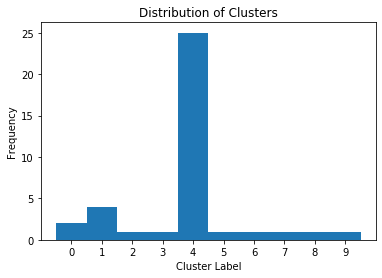

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# set number of clusters
# I chose a high number to see an effect (otherwise most are in the same cluster)
kclusters = 10

torontoGroupedClustering = torontoGrouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(torontoGroupedClustering)

# check cluster labels generated for each row in the dataframe
plt.hist(kmeans.labels_, bins=np.arange(0,kclusters+1))
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.title('Distribution of Clusters')
plt.xticks(np.arange(0,kclusters) + 0.5, list(np.arange(0,kclusters)))
plt.show()

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [35]:
toronto_merged = torontoTableReduced
toronto_merged = toronto_merged.rename(columns={'Neighborhood': 'Neighborhoods'})

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhoods')

toronto_merged.head(10) # check the last columns!

,PostalCode,Borough,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Sandwich Place,Pizza Place,Pet Store,Movie Theater,Brewery,Burger Joint,Burrito Place,Pub,Park,Fast Food Restaurant
1,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,4,Coffee Shop,Restaurant,Café,Hotel,Seafood Restaurant,Beer Bar,Italian Restaurant,Fast Food Restaurant,Cocktail Bar,Lounge
2,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,4,Coffee Shop,Café,Bar,Steakhouse,American Restaurant,Thai Restaurant,Restaurant,Hotel,Asian Restaurant,Burger Joint
3,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,4,Coffee Shop,Café,Sandwich Place,Pizza Place,History Museum,BBQ Joint,Indian Restaurant,Jewish Restaurant,Liquor Store,Cosmetics Shop
4,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,4,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Italian Restaurant,Gastropub,Deli / Bodega,Gym,Steakhouse
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,4,Coffee Shop,Café,Italian Restaurant,Ice Cream Shop,Burger Joint,Sandwich Place,Japanese Restaurant,Gym / Fitness Center,Chinese Restaurant,Bar
6,M4E,East Toronto,The Beaches,43.676357,-79.293031,7,Health Food Store,Park,Other Great Outdoors,Neighborhood,Trail,Pub,Electronics Store,Doner Restaurant,Donut Shop,Dumpling Restaurant
7,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,4,Sushi Restaurant,Coffee Shop,Café,Italian Restaurant,Fish & Chips Shop,Boutique,Restaurant,Smoothie Shop,Latin American Restaurant,Diner
8,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,4,Coffee Shop,Cocktail Bar,Farmers Market,Café,Cheese Shop,Beer Bar,Steakhouse,Seafood Restaurant,Bakery,Irish Pub
9,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,4,Coffee Shop,Park,Bakery,Café,Breakfast Spot,Restaurant,Mexican Restaurant,Pub,Theater,Beer Store


### 3.9 Show clustered Neighbourhoods on the Map

In [36]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map of New York using latitude and longitude values
map_toronto_clust = folium.Map(location=[locToronto.latitude, locToronto.longitude], zoom_start=11)

# color map
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, neighborhood, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhoods'], toronto_merged['Cluster Labels']):
    #label = '{}, {}'.format(borough, postcode)
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color = rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto